<a href="https://colab.research.google.com/github/adsamaz/Chattbot/blob/master/chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
from collections import Counter



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def preprocess_pandas(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data['Sentence'] = data['Sentence'].str.lower()
    data['Sentence'] = data['Sentence'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['Sentence'] = data['Sentence'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')                                                       # remove special characters
    data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)                                                   # remove numbers
    for index, row in data.iterrows():
        word_tokens = word_tokenize(row['Sentence'])
        filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
        df_ = df_.append({
            "index": row['index'],
            "Class": row['Class'],
            "Sentence": " ".join(filtered_sent[0:])
        }, ignore_index=True)
    return data

In [37]:
# If this is the primary file that is executed (ie not an import of another file)
if __name__ == "__main__":
    # get data, pre-process and split
    data = pd.read_csv("https://raw.githubusercontent.com/adsamaz/Chattbot/master/ANN_project_files/amazon_cells_labelled.txt?token=AL267CS3JPVMWZZ453JJJBC56NPZO", delimiter='\t', header=None)
    data.columns = ['Sentence', 'Class']
    data['index'] = data.index                                          # add new column index
    columns = ['index', 'Class', 'Sentence']
    data = preprocess_pandas(data, columns)                             # pre-process
    training_data, validation_data, training_labels, validation_labels = train_test_split( # split the data into training, validation, and test splits
        data['Sentence'].values.astype('U'),
        data['Class'].values.astype('int32'),
        test_size=0.10,
        random_state=0,
        shuffle=True
    )
    print(training_data.shape)

    # vectorize data using TFIDF and transform for PyTorch for scalability
    word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')
    training_data = word_vectorizer.fit_transform(training_data)        # transform texts to sparse matrix
    training_data = training_data.todense()                             # convert to dense matrix for Pytorch
    vocab_size = len(word_vectorizer.vocabulary_)
    validation_data = word_vectorizer.transform(validation_data)
    validation_data = validation_data.todense()
    train_x_tensor = torch.from_numpy(np.array(training_data)).type(torch.FloatTensor)
    train_y_tensor = torch.from_numpy(np.array(training_labels)).long()
    validation_x_tensor = torch.from_numpy(np.array(validation_data)).type(torch.FloatTensor)
    validation_y_tensor = torch.from_numpy(np.array(validation_labels)).long()

    data=data.get(['Sentence','Class'])
    reviews = data.Sentence
    labels = data.Class

    print(data)

(900,)
                                              Sentence  Class
0    so there is no way for me to plug it in here i...      0
1                            good case excellent value      1
2                                great for the jawbone      1
3    tied to charger for conversations lasting more...      0
4                                     the mic is great      1
..                                                 ...    ...
995  the screen does get smudged easily because it ...      0
996  what a piece of junk i lose more calls on this...      0
997                        item does not match picture      0
998  the only thing that disappoint me is the infra...      0
999  you can not answer calls with the unit never w...      0

[1000 rows x 2 columns]


In [5]:
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('/content/drive/My Drive/Chatbot_shared/reviews_Video_Games_5.json.gz')
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2HD75EMZR8QLN,0700099867,123,"[8, 12]",Installing the game was a struggle (because of...,1.0,Pay to unlock content? I don't think so.,1341792000,"07 9, 2012"
1,A3UR8NLLY1ZHCX,0700099867,"Alejandro Henao ""Electronic Junky""","[0, 0]",If you like rally cars get this game you will ...,4.0,Good rally game,1372550400,"06 30, 2013"
2,A1INA0F5CWW3J4,0700099867,"Amazon Shopper ""Mr.Repsol""","[0, 0]",1st shipment received a book instead of the ga...,1.0,Wrong key,1403913600,"06 28, 2014"
3,A1DLMTOTHQ4AST,0700099867,ampgreen,"[7, 10]","I got this version instead of the PS3 version,...",3.0,"awesome game, if it did not crash frequently !!",1315958400,"09 14, 2011"
4,A361M14PU2GUEG,0700099867,"Angry Ryan ""Ryan A. Forrest""","[2, 2]",I had Dirt 2 on Xbox 360 and it was an okay ga...,4.0,DIRT 3,1308009600,"06 14, 2011"
...,...,...,...,...,...,...,...,...,...
231775,A1ICREREXO9J81,B00KHECZXO,Frustrated gamer,"[0, 1]",Funny people on here are rating sellers that a...,5.0,this is for rating the system not the seller,1405814400,"07 20, 2014"
231776,A3VVMIMMTYQV5F,B00KHECZXO,Johnny Saigon,"[8, 11]",All this is is the Deluxe 32GB Wii U with Mari...,1.0,Get the Other Bundle Which Includes Extra Whee...,1403308800,"06 21, 2014"
231777,A1DD4B97M4DUC5,B00KHECZXO,migit,"[62, 66]",The package should have more red on it and sho...,1.0,Fake bundle,1401321600,"05 29, 2014"
231778,A2Q9CNJ4T6ZK99,B00KHECZXO,"Philip Brown ""Philip & Chana""","[33, 36]",Can get this at Newegg for $329.00 and the pac...,1.0,Looks Like We Have Gougers Again.,1401667200,"06 2, 2014"


In [6]:
#Removes everything in except the review and overall score. Then removes
# all reviews with an score of 3 beacuse of them being natrual when we set all
#score under 3 to 0(negative) and score over 3 to 1(positive)
#df=data
df=df.get(['reviewText','overall'])
df=df[df.overall != 3.0] 
df=df.replace(1.0, 0)
df=df.replace(2.0, 0)
df=df.replace(4.0, 1)
df=df.replace(5.0, 1)
reviews = df.reviewText
labels = df.overall
df


,reviewText,overall
0,Installing the game was a struggle (because of...,0.0
1,If you like rally cars get this game you will ...,1.0
2,1st shipment received a book instead of the ga...,0.0
4,I had Dirt 2 on Xbox 360 and it was an okay ga...,1.0
5,"Overall this is a well done racing game, with ...",1.0
...,...,...
231775,Funny people on here are rating sellers that a...,1.0
231776,All this is is the Deluxe 32GB Wii U with Mari...,0.0
231777,The package should have more red on it and sho...,0.0
231778,Can get this at Newegg for $329.00 and the pac...,0.0


In [38]:
#Removes symbols and lowercases all characters
reviews = reviews.str.lower()
reviews = reviews.str.replace(r'[^\w\s]+','')
len(reviews)

1000

In [39]:
#Tokenizer
all_text = ' '.join(reviews)          # Makes on string of all texts.
words = all_text.split()

#Count all the words
count_words = Counter(words)          # Creats a counter function

# Sort words after which is most common
total_words = len(words)
sorted_words = count_words.most_common(total_words)
sorted_words

[('the', 513),
 ('i', 316),
 ('and', 310),
 ('it', 281),
 ('is', 243),
 ('a', 218),
 ('this', 206),
 ('to', 196),
 ('phone', 162),
 ('my', 143),
 ('for', 121),
 ('of', 120),
 ('not', 117),
 ('with', 112),
 ('very', 103),
 ('great', 97),
 ('was', 90),
 ('on', 89),
 ('in', 88),
 ('that', 80),
 ('good', 77),
 ('have', 73),
 ('you', 68),
 ('product', 55),
 ('quality', 49),
 ('had', 48),
 ('headset', 47),
 ('works', 47),
 ('but', 46),
 ('battery', 45),
 ('as', 45),
 ('its', 43),
 ('so', 42),
 ('are', 42),
 ('sound', 41),
 ('all', 41),
 ('use', 41),
 ('one', 40),
 ('well', 38),
 ('ear', 35),
 ('has', 34),
 ('would', 34),
 ('work', 34),
 ('from', 33),
 ('your', 32),
 ('dont', 31),
 ('like', 30),
 ('case', 29),
 ('if', 29),
 ('me', 28),
 ('than', 28),
 ('be', 28),
 ('ive', 28),
 ('excellent', 27),
 ('time', 27),
 ('after', 27),
 ('price', 27),
 ('no', 26),
 ('up', 26),
 ('recommend', 26),
 ('does', 26),
 ('really', 26),
 ('at', 24),
 ('im', 24),
 ('or', 23),
 ('best', 23),
 ('service', 23),
 (

In [40]:
# Creats a vocabulary where each number corresponds to a word.

vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

# Changes all word in reviews to interger values accoriding to vocab_to_int
reviews_int = []
for review in reviews:
    r = [vocab_to_int[w] for w in review.split()]
    reviews_int.append(r)
print (reviews_int[0:3])


[[33, 115, 5, 58, 210, 11, 50, 8, 153, 4, 19, 326, 19, 1, 533, 534, 2, 234, 185, 6, 786], [21, 48, 54, 262], [16, 11, 1, 403]]


In [41]:
encoded_labels = np.array(labels)
encoded_labels

array([0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,

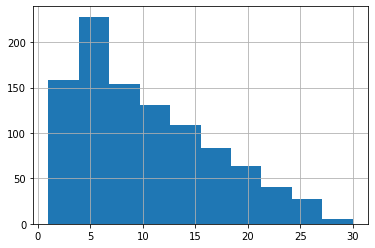

count    1000.000000
mean       10.118000
std         6.598456
min         1.000000
25%         5.000000
50%         9.000000
75%        15.000000
max        30.000000
dtype: float64

In [42]:
#Prints a visualisation of how many word there are in each review
reviews_len = [len(x) for x in reviews_int]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

In [0]:
# Removes all reviews which have zero words in them.

reviews_int = [ reviews_int[i] for i, l in enumerate(reviews_len) if l>0 ]
encoded_labels = [ encoded_labels[i] for i, l in enumerate(reviews_len) if l> 0 ]

In [0]:
# Fucntion which zero padds and shortens all reviews to seq_length

def pad_features(reviews_int, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review        
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features


In [45]:
features = np.array(pad_features(reviews_int,200))
features[10][:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [46]:
# SPlitting data into training, validation and testing
split_frac = 0.6
len_feat=len(features)
encoded_labels = np.array(encoded_labels)

train_x = features[0:int(split_frac*len_feat)]
train_y = encoded_labels[0:int(split_frac*len_feat)]
remaining_x = features[int(split_frac*len_feat):]
remaining_y = encoded_labels[int(split_frac*len_feat):]
valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
valid_y = remaining_y[0:int(len(remaining_y)*0.5)]
test_x = remaining_x[int(len(remaining_x)*0.5):]
test_y = remaining_y[int(len(remaining_y)*0.5):]


type(train_y)

numpy.ndarray

In [0]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data. removes last incomplete batch
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size,drop_last=True)

In [48]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) 
# batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) 
# batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 200])
Sample input: 
 tensor([[   0,    0,    0,  ...,    7, 1336,    4],
        [   0,    0,    0,  ...,    5, 1032,  464],
        [   0,    0,    0,  ...,   27,  273,  139],
        ...,
        [   0,    0,    0,  ...,   78,    7,    9],
        [   0,    0,    0,  ...,    0,  121,  122],
        [   0,    0,    0,  ...,    6,   16,    9]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 1])


In [30]:
from gensim.models import KeyedVectors

# Load embeddings from the pre-trained file
# The file can be found in Canvas and must be placed in the same directory as the notebook)
fastText_embeddings = KeyedVectors.load_word2vec_format('/content/drive/My Drive/Chatbot_shared/wiki.simple.vec')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [57]:
#Creating own embeddinglayer # TEEEEST
emb_dim = 300  #Embedding dim
matrix_len = len(sorted_words)
weights_matrix = np.zeros((matrix_len, 300))
words_found = 0

for i, word in enumerate(sorted_words):
    try: 
        weights_matrix[i] = fastText_embeddings[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(emb_dim, ))

print(weights_matrix.shape)
print(len(sorted_words))      

(1856, 300)
1856
10118


In [50]:
word='sweden'
#print(words[0])
test1=fastText_embeddings['sweden']
test2=fastText_embeddings['norway']

print(len(test1))
from scipy import spatial

result = 1 - spatial.distance.cosine(test1, test2)

print(result)

fastText_embeddings.most_similar(positive=['sweden'])

print(fastText_embeddings.wv.vectors.shape)

weights = torch.FloatTensor(fastText_embeddings.vectors)

print(weights)


300
0.597154974937439
(111051, 300)
tensor([[ 0.2892, -0.4608,  0.3514,  ...,  0.1331, -0.2347,  0.0053],
        [ 0.0569, -0.0520,  0.2733,  ..., -0.0695, -0.1606, -0.0989],
        [ 0.2013,  0.0104,  0.1623,  ..., -0.0931, -0.1408, -0.1326],
        ...,
        [ 0.2377, -0.0403, -0.0326,  ..., -0.0606,  0.0348, -0.2974],
        [ 0.5376, -0.2263,  0.0231,  ...,  0.0800, -0.3782, -0.2765],
        [ 0.1598,  0.0028, -0.2026,  ..., -0.0032, -0.1265, -0.1526]])


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app


TypeError: ignored

In [20]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [0]:


class SentimentNet(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [0]:
vocab_size = len(vocab_to_int) + 1
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

model = SentimentNet(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model.to(device)

lr=0.005
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [25]:
from tqdm import tqdm
epochs = 20
counter = 0
print_every = 6
clip = 5
valid_loss_min = np.Inf
# Create a list to keep track of how the loss changes
train_losses = []
validate_losses = []

model.train()
for i in (range(epochs)):
    h = model.init_hidden(batch_size)

    # A variable for containing the sum of all batch losses for this epoch
    train_loss = 0
    validate_loss = 0

    
    #Train step
    counter = 0
    for inputs, labels in (train_loader):
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        train_loss += loss.item()
        print(
            '\rEpoch {} [{}/{}] - Loss: {}'.format(
                i+1, counter, len(train_loader), loss
            ),
            end=''
        )
    print('\n')


    #Validation Step
    counter = 0
    val_h = model.init_hidden(batch_size)
    val_losses = []
    model.eval()
    for inp, lab in valid_loader:
        counter += 1
        val_h = tuple([each.data for each in val_h])
        inp, lab = inp.to(device), lab.to(device)
        out, val_h = model(inp, val_h)
        val_loss = criterion(out.squeeze(), lab.float())
        val_losses.append(val_loss.item())
        validate_loss += val_loss.item()
        print(
            '\rValidation of Epoch {} [{}/{}] - Loss: {}'.format(
                i+1, counter, len(valid_loader), loss
            ),
            end=''
        )
    print('\n')

    #Append the epoch loss to the list of losses
    train_losses.append(train_loss/len(train_loader))
    validate_losses.append(validate_loss/len(valid_loader))
        
    model.train()
    if np.mean(val_losses) <= valid_loss_min:
        torch.save(model.state_dict(), './state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...\n'.format(valid_loss_min,np.mean(val_losses)))
        valid_loss_min = np.mean(val_losses)

Epoch 1 [2441/2441] - Loss: 0.4446130394935608

Validation of Epoch 1 [813/813] - Loss: 0.4446130394935608

Validation loss decreased (inf --> 0.224193).  Saving model ...

Epoch 2 [2441/2441] - Loss: 0.2100984752178192

Validation of Epoch 2 [813/813] - Loss: 0.2100984752178192

Epoch 3 [2441/2441] - Loss: 0.12451872229576111

Validation of Epoch 3 [813/813] - Loss: 0.12451872229576111

Epoch 4 [2441/2441] - Loss: 0.06757543236017227

Validation of Epoch 4 [813/813] - Loss: 0.06757543236017227

Epoch 5 [2441/2441] - Loss: 0.2282753586769104

Validation of Epoch 5 [813/813] - Loss: 0.2282753586769104

Epoch 6 [2441/2441] - Loss: 0.1135149598121643

Validation of Epoch 6 [813/813] - Loss: 0.1135149598121643

Epoch 7 [2441/2441] - Loss: 0.06616692245006561

Validation of Epoch 7 [813/813] - Loss: 0.06616692245006561

Epoch 8 [2441/2441] - Loss: 0.07224038243293762

Validation of Epoch 8 [813/813] - Loss: 0.07224038243293762

Epoch 9 [2441/2441] - Loss: 0.02987036667764187

Validation of 

In [26]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

test_losses = []
num_correct = 0
h = model.init_hidden(batch_size)

model.eval()
for inputs, labels in test_loader:
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output.squeeze())  # Rounds the output to 0/1
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))

Test loss: 0.211
Test accuracy: 91.736%


Results


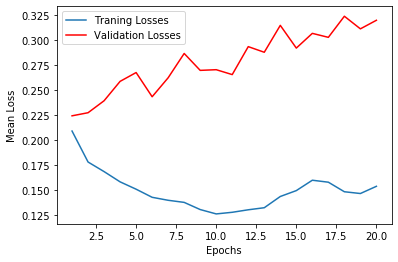

813

In [29]:
# Plot the mean training and validation loss per epoch

print("Results")

line1 = plt.plot(range(1,epochs+1),train_losses,label='Traning Losses')
line2 = plt.plot(range(1,epochs+1),validate_losses,'r',label='Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Mean Loss')
plt.legend()
plt.show()

len(val_losses)